# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

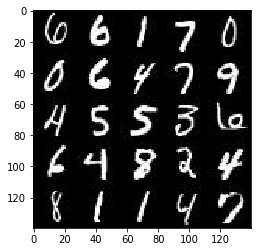

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

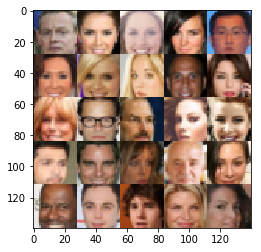

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None, name="lr")
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        
        x1 = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x2 = tf.reshape(x2, (-1,4*4*256))
        logits = tf.layers.dense(x2, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        x = tf.layers.dense(z, 7*7*512)

        x = tf.reshape(x, (-1, 7, 7, 512))
        
        x1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        x1 = tf.layers.batch_normalization(x1 , training = is_train)
        x1 = tf.maximum(alpha*x1 , x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2 , training = is_train)
        x2 = tf.maximum(alpha*x2 , x2)
        

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim)
    real_output, real_logits = discriminator(input_real)
    fake_outptut, fake_logits = discriminator(g_output, reuse = True)
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_logits, labels= (tf.ones_like(real_output)*(1 - smooth))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_logits, labels= tf.zeros_like(fake_logits)))
    
    d_loss = d_loss_real+d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_logits, labels = tf.ones_like(fake_logits)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optm = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1= beta1).minimize(d_loss, var_list = d_vars)
        g_optm = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return (d_optm, g_optm)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, out_channel_dim = data_shape
    input_real , input_z, lr = model_inputs(image_width, image_height, out_channel_dim,  z_dim)
    
    d_loss, g_loss = model_loss(input_real , input_z, out_channel_dim)
    
    d_train,g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1 ,(batch_size, z_dim))
                _ = sess.run(d_train, feed_dict = {input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict = {input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps%10 ==0:
                    
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z:batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i+1,epoch_count),"Discriminator_Loss: {:.4f}".format(train_loss_d),"Generator_Loss: {:.4f}".format(train_loss_g))
                if steps%100==0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                    

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator_Loss: 1.5601 Generator_Loss: 5.7987
Epoch 1/2 Discriminator_Loss: 1.9034 Generator_Loss: 5.3397
Epoch 1/2 Discriminator_Loss: 2.1536 Generator_Loss: 2.5558
Epoch 1/2 Discriminator_Loss: 1.2296 Generator_Loss: 2.2859
Epoch 1/2 Discriminator_Loss: 1.4864 Generator_Loss: 0.5368
Epoch 1/2 Discriminator_Loss: 1.3822 Generator_Loss: 0.5817
Epoch 1/2 Discriminator_Loss: 1.3522 Generator_Loss: 0.5842
Epoch 1/2 Discriminator_Loss: 1.6952 Generator_Loss: 1.5644
Epoch 1/2 Discriminator_Loss: 1.7741 Generator_Loss: 0.3470
Epoch 1/2 Discriminator_Loss: 1.2789 Generator_Loss: 0.9732


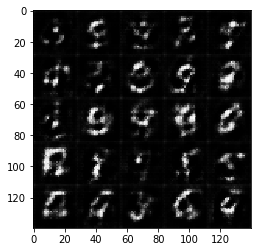

Epoch 1/2 Discriminator_Loss: 1.2316 Generator_Loss: 1.1639
Epoch 1/2 Discriminator_Loss: 1.3627 Generator_Loss: 0.6252
Epoch 1/2 Discriminator_Loss: 1.3314 Generator_Loss: 1.1562
Epoch 1/2 Discriminator_Loss: 1.2163 Generator_Loss: 1.0647
Epoch 1/2 Discriminator_Loss: 1.1936 Generator_Loss: 1.0294
Epoch 1/2 Discriminator_Loss: 1.3532 Generator_Loss: 0.5802
Epoch 1/2 Discriminator_Loss: 1.2518 Generator_Loss: 1.3774
Epoch 1/2 Discriminator_Loss: 1.4671 Generator_Loss: 0.4849
Epoch 1/2 Discriminator_Loss: 1.3689 Generator_Loss: 0.5357
Epoch 1/2 Discriminator_Loss: 1.1768 Generator_Loss: 1.2656


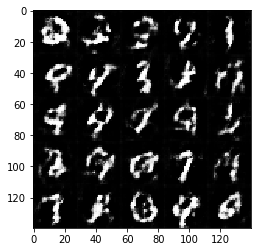

Epoch 1/2 Discriminator_Loss: 1.3863 Generator_Loss: 0.5823
Epoch 1/2 Discriminator_Loss: 1.1583 Generator_Loss: 1.1430
Epoch 1/2 Discriminator_Loss: 1.2136 Generator_Loss: 1.1067
Epoch 1/2 Discriminator_Loss: 1.3308 Generator_Loss: 0.5656
Epoch 1/2 Discriminator_Loss: 1.3096 Generator_Loss: 1.0697
Epoch 1/2 Discriminator_Loss: 1.5257 Generator_Loss: 1.5872
Epoch 1/2 Discriminator_Loss: 1.2957 Generator_Loss: 1.1339
Epoch 1/2 Discriminator_Loss: 1.4316 Generator_Loss: 1.9204
Epoch 1/2 Discriminator_Loss: 1.1548 Generator_Loss: 1.0304
Epoch 1/2 Discriminator_Loss: 1.2686 Generator_Loss: 0.6680


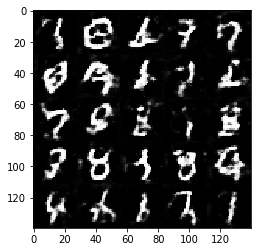

Epoch 1/2 Discriminator_Loss: 1.1559 Generator_Loss: 1.3484
Epoch 1/2 Discriminator_Loss: 1.1261 Generator_Loss: 1.2502
Epoch 1/2 Discriminator_Loss: 1.1359 Generator_Loss: 1.0842
Epoch 1/2 Discriminator_Loss: 1.2602 Generator_Loss: 1.4031
Epoch 1/2 Discriminator_Loss: 1.1446 Generator_Loss: 1.3477
Epoch 1/2 Discriminator_Loss: 1.6028 Generator_Loss: 0.4225
Epoch 1/2 Discriminator_Loss: 1.5444 Generator_Loss: 2.3248
Epoch 1/2 Discriminator_Loss: 1.0994 Generator_Loss: 0.9519
Epoch 1/2 Discriminator_Loss: 1.0685 Generator_Loss: 1.0165
Epoch 1/2 Discriminator_Loss: 1.1518 Generator_Loss: 0.7809


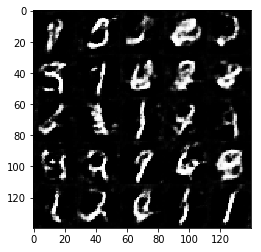

Epoch 1/2 Discriminator_Loss: 1.0776 Generator_Loss: 1.0663
Epoch 1/2 Discriminator_Loss: 1.1699 Generator_Loss: 1.9053
Epoch 1/2 Discriminator_Loss: 1.1555 Generator_Loss: 1.8880
Epoch 1/2 Discriminator_Loss: 1.1785 Generator_Loss: 0.7594
Epoch 1/2 Discriminator_Loss: 1.3554 Generator_Loss: 0.5311
Epoch 1/2 Discriminator_Loss: 1.1319 Generator_Loss: 0.7891
Epoch 2/2 Discriminator_Loss: 1.1346 Generator_Loss: 1.6180
Epoch 2/2 Discriminator_Loss: 1.0952 Generator_Loss: 1.1104
Epoch 2/2 Discriminator_Loss: 1.2764 Generator_Loss: 1.5172
Epoch 2/2 Discriminator_Loss: 1.0270 Generator_Loss: 1.3840


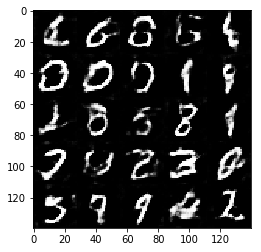

Epoch 2/2 Discriminator_Loss: 1.0743 Generator_Loss: 1.6025
Epoch 2/2 Discriminator_Loss: 1.2027 Generator_Loss: 1.9936
Epoch 2/2 Discriminator_Loss: 1.0278 Generator_Loss: 1.4943
Epoch 2/2 Discriminator_Loss: 1.0080 Generator_Loss: 1.1948
Epoch 2/2 Discriminator_Loss: 1.1595 Generator_Loss: 0.7855
Epoch 2/2 Discriminator_Loss: 0.9744 Generator_Loss: 1.0149
Epoch 2/2 Discriminator_Loss: 0.9087 Generator_Loss: 1.2576
Epoch 2/2 Discriminator_Loss: 1.3641 Generator_Loss: 0.5721
Epoch 2/2 Discriminator_Loss: 1.3057 Generator_Loss: 1.4373
Epoch 2/2 Discriminator_Loss: 1.2338 Generator_Loss: 0.7639


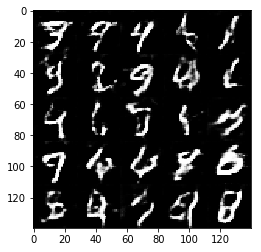

Epoch 2/2 Discriminator_Loss: 1.2098 Generator_Loss: 0.8103
Epoch 2/2 Discriminator_Loss: 1.3596 Generator_Loss: 0.5478
Epoch 2/2 Discriminator_Loss: 1.1014 Generator_Loss: 0.8925
Epoch 2/2 Discriminator_Loss: 1.2770 Generator_Loss: 0.6141
Epoch 2/2 Discriminator_Loss: 1.0904 Generator_Loss: 1.7827
Epoch 2/2 Discriminator_Loss: 0.9844 Generator_Loss: 0.9776
Epoch 2/2 Discriminator_Loss: 1.1492 Generator_Loss: 1.1257
Epoch 2/2 Discriminator_Loss: 1.2161 Generator_Loss: 1.2932
Epoch 2/2 Discriminator_Loss: 1.2037 Generator_Loss: 1.3692
Epoch 2/2 Discriminator_Loss: 1.1470 Generator_Loss: 1.4058


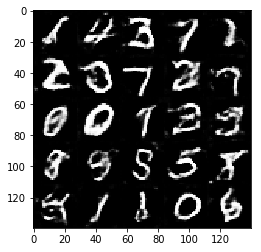

Epoch 2/2 Discriminator_Loss: 1.1172 Generator_Loss: 0.8382
Epoch 2/2 Discriminator_Loss: 1.2481 Generator_Loss: 1.9587
Epoch 2/2 Discriminator_Loss: 0.9118 Generator_Loss: 1.1725
Epoch 2/2 Discriminator_Loss: 1.1831 Generator_Loss: 1.8981
Epoch 2/2 Discriminator_Loss: 1.0041 Generator_Loss: 1.2994
Epoch 2/2 Discriminator_Loss: 0.9445 Generator_Loss: 1.0875
Epoch 2/2 Discriminator_Loss: 1.9792 Generator_Loss: 0.3783
Epoch 2/2 Discriminator_Loss: 0.9533 Generator_Loss: 1.0274
Epoch 2/2 Discriminator_Loss: 0.9334 Generator_Loss: 1.3842
Epoch 2/2 Discriminator_Loss: 2.5310 Generator_Loss: 3.5937


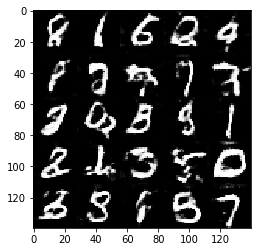

Epoch 2/2 Discriminator_Loss: 1.1207 Generator_Loss: 0.7897
Epoch 2/2 Discriminator_Loss: 1.0334 Generator_Loss: 0.9841
Epoch 2/2 Discriminator_Loss: 0.8375 Generator_Loss: 1.3219
Epoch 2/2 Discriminator_Loss: 1.2721 Generator_Loss: 0.6448
Epoch 2/2 Discriminator_Loss: 0.9137 Generator_Loss: 1.3905
Epoch 2/2 Discriminator_Loss: 1.0028 Generator_Loss: 2.3229
Epoch 2/2 Discriminator_Loss: 1.4109 Generator_Loss: 0.5457
Epoch 2/2 Discriminator_Loss: 1.0339 Generator_Loss: 0.8365
Epoch 2/2 Discriminator_Loss: 1.3863 Generator_Loss: 0.5609
Epoch 2/2 Discriminator_Loss: 1.0064 Generator_Loss: 0.9462


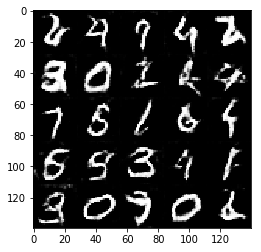

Epoch 2/2 Discriminator_Loss: 0.7811 Generator_Loss: 1.2967
Epoch 2/2 Discriminator_Loss: 1.0890 Generator_Loss: 0.9234
Epoch 2/2 Discriminator_Loss: 1.0570 Generator_Loss: 1.0396


In [39]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator_Loss: 1.3002 Generator_Loss: 0.9485
Epoch 1/1 Discriminator_Loss: 1.8516 Generator_Loss: 0.4016
Epoch 1/1 Discriminator_Loss: 1.3787 Generator_Loss: 0.8030
Epoch 1/1 Discriminator_Loss: 1.5163 Generator_Loss: 1.1277
Epoch 1/1 Discriminator_Loss: 1.4806 Generator_Loss: 0.6567
Epoch 1/1 Discriminator_Loss: 1.4345 Generator_Loss: 1.4636
Epoch 1/1 Discriminator_Loss: 1.6152 Generator_Loss: 0.4900
Epoch 1/1 Discriminator_Loss: 1.4600 Generator_Loss: 1.1613
Epoch 1/1 Discriminator_Loss: 1.3288 Generator_Loss: 0.9370
Epoch 1/1 Discriminator_Loss: 1.3651 Generator_Loss: 0.7523


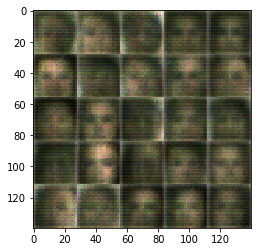

Epoch 1/1 Discriminator_Loss: 1.4946 Generator_Loss: 1.3806
Epoch 1/1 Discriminator_Loss: 1.4596 Generator_Loss: 0.7135
Epoch 1/1 Discriminator_Loss: 1.8745 Generator_Loss: 1.9842
Epoch 1/1 Discriminator_Loss: 1.4204 Generator_Loss: 0.6680
Epoch 1/1 Discriminator_Loss: 1.3662 Generator_Loss: 1.2077
Epoch 1/1 Discriminator_Loss: 1.1843 Generator_Loss: 0.9156
Epoch 1/1 Discriminator_Loss: 1.5996 Generator_Loss: 0.7885
Epoch 1/1 Discriminator_Loss: 1.3792 Generator_Loss: 0.9618
Epoch 1/1 Discriminator_Loss: 1.3037 Generator_Loss: 0.9824
Epoch 1/1 Discriminator_Loss: 1.5109 Generator_Loss: 0.7990


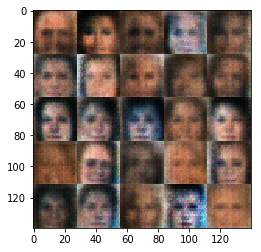

Epoch 1/1 Discriminator_Loss: 1.4524 Generator_Loss: 0.7445
Epoch 1/1 Discriminator_Loss: 1.6811 Generator_Loss: 0.5015
Epoch 1/1 Discriminator_Loss: 1.6392 Generator_Loss: 0.5157
Epoch 1/1 Discriminator_Loss: 1.4752 Generator_Loss: 0.8153
Epoch 1/1 Discriminator_Loss: 1.6409 Generator_Loss: 0.8461
Epoch 1/1 Discriminator_Loss: 1.3031 Generator_Loss: 0.8562
Epoch 1/1 Discriminator_Loss: 1.5965 Generator_Loss: 0.9477
Epoch 1/1 Discriminator_Loss: 1.5083 Generator_Loss: 0.7825
Epoch 1/1 Discriminator_Loss: 1.3882 Generator_Loss: 0.8402
Epoch 1/1 Discriminator_Loss: 1.4377 Generator_Loss: 0.7867


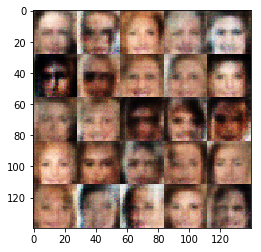

Epoch 1/1 Discriminator_Loss: 1.3235 Generator_Loss: 0.7878
Epoch 1/1 Discriminator_Loss: 1.4320 Generator_Loss: 0.7730
Epoch 1/1 Discriminator_Loss: 1.3822 Generator_Loss: 0.7776
Epoch 1/1 Discriminator_Loss: 1.5296 Generator_Loss: 0.6073
Epoch 1/1 Discriminator_Loss: 1.4886 Generator_Loss: 0.8942
Epoch 1/1 Discriminator_Loss: 1.4239 Generator_Loss: 0.6916
Epoch 1/1 Discriminator_Loss: 1.4222 Generator_Loss: 0.6745
Epoch 1/1 Discriminator_Loss: 1.3973 Generator_Loss: 0.8127
Epoch 1/1 Discriminator_Loss: 1.2367 Generator_Loss: 0.8760
Epoch 1/1 Discriminator_Loss: 1.4410 Generator_Loss: 0.7288


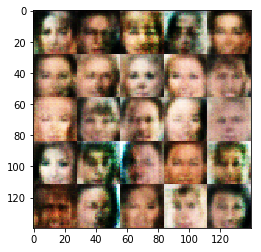

Epoch 1/1 Discriminator_Loss: 1.4101 Generator_Loss: 0.8347
Epoch 1/1 Discriminator_Loss: 1.3923 Generator_Loss: 0.9595
Epoch 1/1 Discriminator_Loss: 1.3641 Generator_Loss: 0.8912
Epoch 1/1 Discriminator_Loss: 1.4626 Generator_Loss: 0.9042
Epoch 1/1 Discriminator_Loss: 1.5146 Generator_Loss: 0.8337
Epoch 1/1 Discriminator_Loss: 1.3109 Generator_Loss: 0.8673
Epoch 1/1 Discriminator_Loss: 1.3606 Generator_Loss: 0.8002
Epoch 1/1 Discriminator_Loss: 1.4244 Generator_Loss: 0.8722
Epoch 1/1 Discriminator_Loss: 1.4125 Generator_Loss: 0.8584
Epoch 1/1 Discriminator_Loss: 1.4867 Generator_Loss: 0.7589


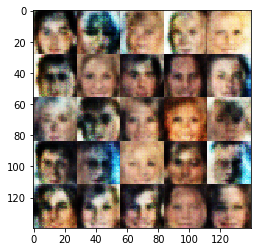

Epoch 1/1 Discriminator_Loss: 1.4285 Generator_Loss: 0.7536
Epoch 1/1 Discriminator_Loss: 1.3912 Generator_Loss: 0.7588
Epoch 1/1 Discriminator_Loss: 1.3676 Generator_Loss: 0.8245
Epoch 1/1 Discriminator_Loss: 1.3722 Generator_Loss: 0.6585
Epoch 1/1 Discriminator_Loss: 1.4933 Generator_Loss: 0.6984
Epoch 1/1 Discriminator_Loss: 1.4195 Generator_Loss: 0.7532
Epoch 1/1 Discriminator_Loss: 1.4020 Generator_Loss: 0.9223
Epoch 1/1 Discriminator_Loss: 1.5517 Generator_Loss: 0.5627
Epoch 1/1 Discriminator_Loss: 1.4301 Generator_Loss: 0.7882
Epoch 1/1 Discriminator_Loss: 1.3616 Generator_Loss: 0.7393


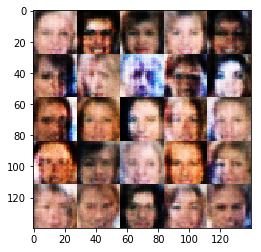

Epoch 1/1 Discriminator_Loss: 1.4050 Generator_Loss: 0.7853
Epoch 1/1 Discriminator_Loss: 1.4308 Generator_Loss: 0.6695
Epoch 1/1 Discriminator_Loss: 1.3518 Generator_Loss: 0.9744
Epoch 1/1 Discriminator_Loss: 1.3110 Generator_Loss: 0.8742
Epoch 1/1 Discriminator_Loss: 1.2919 Generator_Loss: 0.8536
Epoch 1/1 Discriminator_Loss: 1.4087 Generator_Loss: 1.3082
Epoch 1/1 Discriminator_Loss: 1.3022 Generator_Loss: 0.8220
Epoch 1/1 Discriminator_Loss: 1.4850 Generator_Loss: 0.6328
Epoch 1/1 Discriminator_Loss: 1.3657 Generator_Loss: 0.8759
Epoch 1/1 Discriminator_Loss: 1.3766 Generator_Loss: 0.7594


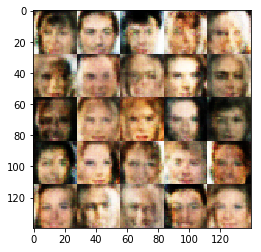

Epoch 1/1 Discriminator_Loss: 1.3645 Generator_Loss: 0.8881
Epoch 1/1 Discriminator_Loss: 1.3294 Generator_Loss: 0.6956
Epoch 1/1 Discriminator_Loss: 1.1700 Generator_Loss: 1.1266
Epoch 1/1 Discriminator_Loss: 1.3993 Generator_Loss: 0.7767
Epoch 1/1 Discriminator_Loss: 1.4317 Generator_Loss: 0.7695
Epoch 1/1 Discriminator_Loss: 1.3838 Generator_Loss: 0.6124
Epoch 1/1 Discriminator_Loss: 1.4184 Generator_Loss: 0.6040
Epoch 1/1 Discriminator_Loss: 1.3681 Generator_Loss: 0.8803
Epoch 1/1 Discriminator_Loss: 1.3792 Generator_Loss: 0.7675
Epoch 1/1 Discriminator_Loss: 1.3083 Generator_Loss: 0.9701


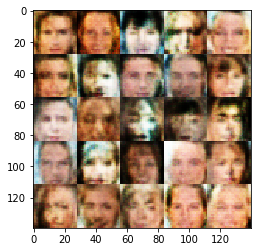

Epoch 1/1 Discriminator_Loss: 1.2632 Generator_Loss: 0.8703
Epoch 1/1 Discriminator_Loss: 1.3592 Generator_Loss: 0.6579
Epoch 1/1 Discriminator_Loss: 1.3589 Generator_Loss: 1.4791
Epoch 1/1 Discriminator_Loss: 1.4493 Generator_Loss: 0.6104
Epoch 1/1 Discriminator_Loss: 1.4418 Generator_Loss: 0.5796
Epoch 1/1 Discriminator_Loss: 1.4347 Generator_Loss: 0.8487
Epoch 1/1 Discriminator_Loss: 1.3543 Generator_Loss: 0.7501
Epoch 1/1 Discriminator_Loss: 1.4020 Generator_Loss: 0.6496
Epoch 1/1 Discriminator_Loss: 1.3837 Generator_Loss: 0.6938
Epoch 1/1 Discriminator_Loss: 1.4166 Generator_Loss: 1.0589


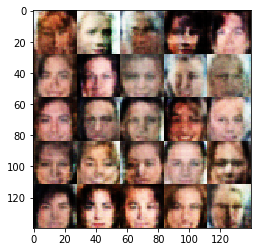

Epoch 1/1 Discriminator_Loss: 1.3237 Generator_Loss: 0.6364
Epoch 1/1 Discriminator_Loss: 1.4379 Generator_Loss: 0.5246
Epoch 1/1 Discriminator_Loss: 1.2750 Generator_Loss: 0.9252
Epoch 1/1 Discriminator_Loss: 1.2864 Generator_Loss: 1.3105
Epoch 1/1 Discriminator_Loss: 1.3582 Generator_Loss: 0.9004
Epoch 1/1 Discriminator_Loss: 1.2636 Generator_Loss: 0.8702
Epoch 1/1 Discriminator_Loss: 1.2747 Generator_Loss: 0.7146
Epoch 1/1 Discriminator_Loss: 1.3311 Generator_Loss: 0.7775
Epoch 1/1 Discriminator_Loss: 1.2246 Generator_Loss: 1.1083
Epoch 1/1 Discriminator_Loss: 1.3883 Generator_Loss: 0.6452


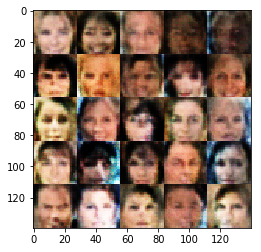

Epoch 1/1 Discriminator_Loss: 1.3147 Generator_Loss: 0.9709
Epoch 1/1 Discriminator_Loss: 1.2598 Generator_Loss: 0.8496
Epoch 1/1 Discriminator_Loss: 1.2752 Generator_Loss: 1.3914
Epoch 1/1 Discriminator_Loss: 1.3051 Generator_Loss: 0.7808
Epoch 1/1 Discriminator_Loss: 1.2154 Generator_Loss: 0.9225
Epoch 1/1 Discriminator_Loss: 1.2815 Generator_Loss: 0.9370
Epoch 1/1 Discriminator_Loss: 1.2247 Generator_Loss: 1.3352
Epoch 1/1 Discriminator_Loss: 1.1112 Generator_Loss: 1.5260
Epoch 1/1 Discriminator_Loss: 1.3041 Generator_Loss: 0.8441
Epoch 1/1 Discriminator_Loss: 1.3567 Generator_Loss: 0.6465


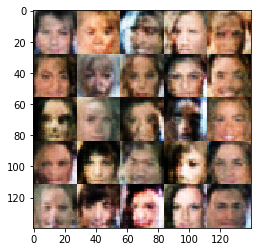

Epoch 1/1 Discriminator_Loss: 1.4168 Generator_Loss: 1.0458
Epoch 1/1 Discriminator_Loss: 1.3569 Generator_Loss: 0.7401
Epoch 1/1 Discriminator_Loss: 1.3458 Generator_Loss: 0.6698
Epoch 1/1 Discriminator_Loss: 1.3376 Generator_Loss: 0.7705
Epoch 1/1 Discriminator_Loss: 1.4127 Generator_Loss: 1.0329
Epoch 1/1 Discriminator_Loss: 1.2194 Generator_Loss: 0.7945
Epoch 1/1 Discriminator_Loss: 1.3538 Generator_Loss: 0.8014
Epoch 1/1 Discriminator_Loss: 1.3474 Generator_Loss: 1.5620
Epoch 1/1 Discriminator_Loss: 1.2506 Generator_Loss: 1.1264
Epoch 1/1 Discriminator_Loss: 1.3643 Generator_Loss: 0.7078


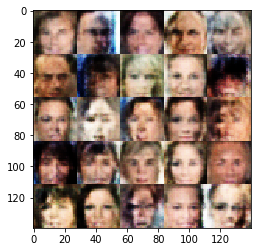

Epoch 1/1 Discriminator_Loss: 1.2976 Generator_Loss: 0.8948
Epoch 1/1 Discriminator_Loss: 1.3992 Generator_Loss: 0.7078
Epoch 1/1 Discriminator_Loss: 0.9829 Generator_Loss: 1.4847
Epoch 1/1 Discriminator_Loss: 1.3622 Generator_Loss: 1.3633
Epoch 1/1 Discriminator_Loss: 1.3539 Generator_Loss: 0.5582
Epoch 1/1 Discriminator_Loss: 1.4838 Generator_Loss: 1.6811
Epoch 1/1 Discriminator_Loss: 1.4800 Generator_Loss: 0.6611
Epoch 1/1 Discriminator_Loss: 1.2051 Generator_Loss: 0.9270
Epoch 1/1 Discriminator_Loss: 1.4008 Generator_Loss: 0.6804
Epoch 1/1 Discriminator_Loss: 1.1702 Generator_Loss: 0.8401


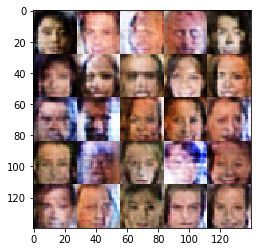

Epoch 1/1 Discriminator_Loss: 1.2301 Generator_Loss: 0.7883
Epoch 1/1 Discriminator_Loss: 1.3770 Generator_Loss: 0.9234
Epoch 1/1 Discriminator_Loss: 1.2350 Generator_Loss: 0.8945
Epoch 1/1 Discriminator_Loss: 1.0527 Generator_Loss: 0.9844
Epoch 1/1 Discriminator_Loss: 1.1294 Generator_Loss: 0.9795
Epoch 1/1 Discriminator_Loss: 1.0751 Generator_Loss: 0.8678
Epoch 1/1 Discriminator_Loss: 1.2726 Generator_Loss: 1.1591
Epoch 1/1 Discriminator_Loss: 1.1397 Generator_Loss: 2.4513
Epoch 1/1 Discriminator_Loss: 1.2272 Generator_Loss: 1.0557
Epoch 1/1 Discriminator_Loss: 1.2234 Generator_Loss: 0.9538


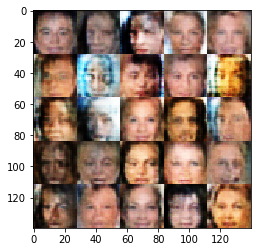

Epoch 1/1 Discriminator_Loss: 1.3718 Generator_Loss: 0.8138
Epoch 1/1 Discriminator_Loss: 1.3550 Generator_Loss: 0.9158
Epoch 1/1 Discriminator_Loss: 1.1767 Generator_Loss: 1.0468
Epoch 1/1 Discriminator_Loss: 1.3598 Generator_Loss: 0.8909
Epoch 1/1 Discriminator_Loss: 1.2778 Generator_Loss: 0.8470
Epoch 1/1 Discriminator_Loss: 1.2751 Generator_Loss: 0.8174
Epoch 1/1 Discriminator_Loss: 1.2029 Generator_Loss: 0.8759


KeyboardInterrupt: 

In [41]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.